# Profits or Losses? Expected Value From Soccer Betting

If I always bet on the favorite team, would I win or lose money?
What if I bet on the second favorite or the least favorite?

In this project, the expected value from soccer betting is discussed. The purpose is to show how good the bookies are at assigning odds to soccer events in order to ensure profits.

This work is informative to the public who wants to know how casinos make money and what is behind the saying: 'The House always wins'.

The data used in this project were obtained from https://www.football-data.co.uk/ and contain information about past soccer games from some of the european leagues, including results and odds. If you want to know more about the data, visit the site.

## Modules

In [1]:
#First import modules
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

## Load and Transform

In [2]:
#Then read all csv and merge them
files = os.listdir()
files = [f for f in files if re.search('csv', f)]
df = pd.DataFrame()
for f in files:
    d = pd.read_csv(f)
    df = pd.concat([df,d])

In [3]:
#Take only necesary columns (FTHG=Goals score by home team, FTAG=Goals score by away team, B365H=Bet 365 Home Odd
#B365D=Bet 365 Draw Odd, B365A=Bet 365 Away Odd)
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A']]

In [4]:
#Create the Result column (0=Home Win, 1=Draw, 2=Away Win)
df['Result'] = np.where(df['FTHG'] > df['FTAG'], 0, np.where(df['FTHG'] == df['FTAG'], 1,2))

In [5]:
#Create a Column for the Win odd
df['WinOdd'] = np.where(df['Result']==0, df['B365H'], np.where(df['Result']==1, df['B365D'], df['B365A']))

In [6]:
# Create a new column with the min odd
df['MinOdd'] = df[['B365H', 'B365D', 'B365A']].min(axis=1)

In [7]:
# Create a new column with the middle odd
df['MiddleOdd'] = df[['B365H', 'B365D', 'B365A']].apply(lambda x: sorted(x)[1], axis=1)

In [8]:
#Create a new column with the max odd
df['MaxOdd'] = df[['B365H', 'B365D', 'B365A']].max(axis=1)

In [9]:
#Create Combined Odd for The two less probale events
df['OddCNF'] = 1/((1/df['MiddleOdd'])+(1/df['MaxOdd']))

In [10]:
#Create Combined Odd for The two more probale events
df['OddSNF'] = 1/((1/df['MiddleOdd'])+(1/df['MinOdd']))

In [11]:
#Create Column with the most probable result according to Odds
df['Fav'] = np.where((df['B365H'] < df['B365D']) & (df['B365H'] < df['B365A']), 0, 
                     np.where((df['B365A'] < df['B365D']) & (df['B365A'] < df['B365H']), 2, 1))

In [12]:
#Create Column with the least probable result according to Odds
df['Les_favorite'] = df[['B365H', 'B365D', 'B365A']].idxmax(axis=1).map({'B365H': 0, 'B365D': 1, 'B365A': 2})

In [13]:
#Drop NA
df = df.dropna()

In [14]:
#Create Column with the second most probable result according to Odds
df['Sec_favorite'] = 3-(df['Fav'].astype(int)+df['Les_favorite'].astype(int))

## Analyzing the strategy: Betting on the two least favorites

In [15]:
#Here we set the won column to 1 if the strategy wins the bet
df['Won'] = np.where(df['Result'] != df['Fav'], 1, 0)
#The we create a profit column, if Won the Odd, else -1
df['profit'] = df['Won'] * df['OddCNF']
df['profit'] = np.where(df['profit']==0, -1, df['profit'])
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,Result,WinOdd,MinOdd,MiddleOdd,MaxOdd,OddCNF,OddSNF,Fav,Les_favorite,Sec_favorite,Won,profit
0,30/07/2022,Dijon,St Etienne,2,1,2.87,3.2,2.37,0,2.87,2.37,2.87,3.20,1.513015,1.298073,2,1.0,0,1,1.513015
1,30/07/2022,Annecy,Niort,1,2,2.30,3.2,2.90,2,2.90,2.30,2.90,3.20,1.521311,1.282692,0,1.0,2,1,1.521311
2,30/07/2022,Bastia,Laval,0,2,2.00,3.1,3.75,2,3.75,2.00,3.10,3.75,1.697080,1.215686,0,2.0,1,1,1.697080
3,30/07/2022,Bordeaux,Valenciennes,0,0,2.50,3.1,2.75,1,3.10,2.50,2.75,3.10,1.457265,1.309524,0,1.0,2,1,1.457265
4,30/07/2022,Guingamp,Pau FC,4,0,1.65,3.5,5.00,0,1.65,1.65,3.50,5.00,2.058824,1.121359,0,2.0,1,0,-1.000000


### Histogram and confidence interval

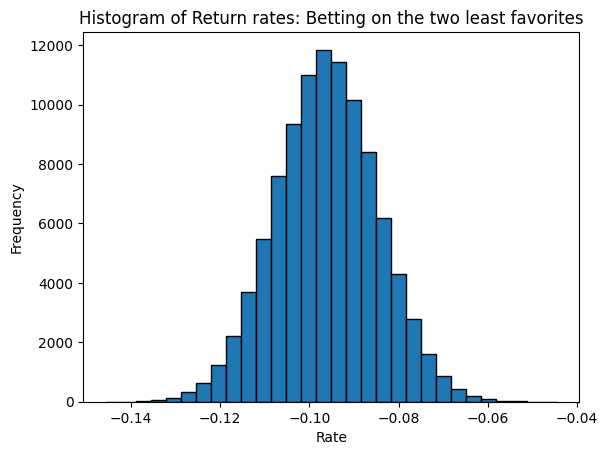

In [16]:
ReturnRate = []
#Run 100000 simulations
for n in range(100000):
    #In each take a sample with replacement of the same lenght than the original df
    df_sample = df.sample(frac=1, replace=True)
    #Calculate the return rate by dividing the profits by the amount bet (Assume 1 dollar bet for all the matches)
    ReturnRate.append((df_sample[df_sample['profit']>0]['profit'].sum() - len(df_sample))/len(df_sample))
plt.hist(ReturnRate, bins=30, edgecolor='k')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Return rates: Betting on the two least favorites')
plt.show()

In [17]:
# Calculate the 90% confidence interval for the Rates
mean_rate = np.mean(ReturnRate)
lower_bound = np.percentile(ReturnRate, 5)
upper_bound = np.percentile(ReturnRate, 95)

print(lower_bound, mean_rate, upper_bound)

-0.11485077895450348 -0.09609414863839233 -0.07722868205483328


After making a bootstrap distribution of the profit rates using this strategy, looks clear that in the long run, we are going to lose money (or the casino will earn money from us). The expected is to lose around 10% of our money. If we establish an interval for this expected value with a 90% confidence, we're going to lose around 11% to 8% of our money (Casino's Profit).

## Analyzing the strategy: Betting on the least favorite

In [18]:
#Here we set the won column to 1 if the strategy wins the bet
df['Won'] = np.where(df['Les_favorite'] == df['Result'], 1,0)
#The we create a profit column, if Won the Odd, else -1
df['profit'] = df['Won'] * df['MaxOdd']
df['profit'] = np.where(df['profit']==0, -1, df['profit'])
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,Result,WinOdd,MinOdd,MiddleOdd,MaxOdd,OddCNF,OddSNF,Fav,Les_favorite,Sec_favorite,Won,profit
0,30/07/2022,Dijon,St Etienne,2,1,2.87,3.2,2.37,0,2.87,2.37,2.87,3.20,1.513015,1.298073,2,1.0,0,0,-1.00
1,30/07/2022,Annecy,Niort,1,2,2.30,3.2,2.90,2,2.90,2.30,2.90,3.20,1.521311,1.282692,0,1.0,2,0,-1.00
2,30/07/2022,Bastia,Laval,0,2,2.00,3.1,3.75,2,3.75,2.00,3.10,3.75,1.697080,1.215686,0,2.0,1,1,3.75
3,30/07/2022,Bordeaux,Valenciennes,0,0,2.50,3.1,2.75,1,3.10,2.50,2.75,3.10,1.457265,1.309524,0,1.0,2,1,3.10
4,30/07/2022,Guingamp,Pau FC,4,0,1.65,3.5,5.00,0,1.65,1.65,3.50,5.00,2.058824,1.121359,0,2.0,1,0,-1.00


### Histogram and confidence interval

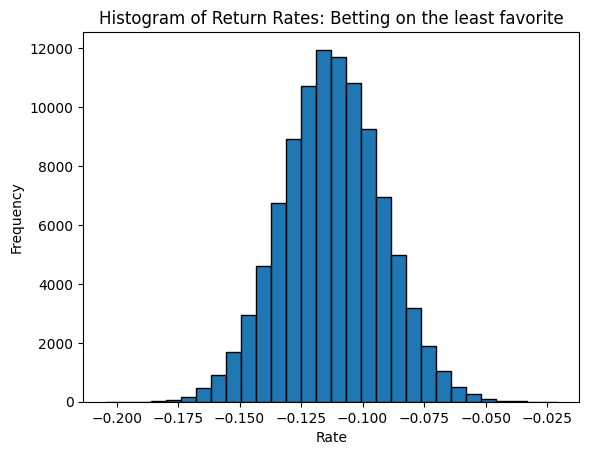

In [19]:
ReturnRate = []
#Run 100000 simulations
for n in range(100000):
    #In each take a sample with replacement of the same lenght than the original df
    df_sample = df.sample(frac=1, replace=True)
    #Calculate the return rate by dividing the profits by the amount bet (Assume 1 dollar bet for all the matches)
    ReturnRate.append((df_sample[df_sample['profit']>0]['profit'].sum() - len(df_sample))/len(df_sample))
plt.hist(ReturnRate, bins=30, edgecolor='k')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Return Rates: Betting on the least favorite')
plt.show()

In [20]:
# Calculate the 90% confidence interval for the Rates
mean_rate = np.mean(ReturnRate)
lower_bound = np.percentile(ReturnRate, 5)
upper_bound = np.percentile(ReturnRate, 95)

print(lower_bound, mean_rate, upper_bound)

-0.14563670163324924 -0.11225531465940777 -0.07871716903465675


After making a bootstrap distribution of the profit rates using this other strategy, it's clear that in the long run, we are going to lose money again (or the casino will earn money from us). We can expect to lose around 11% of our money. If we establish an interval for this expected value with a 90% confidence, we're going to lose around 14% to 8% of our money (Casino's Profit).

## Analyzing the strategy: Betting on the two favorites

In [21]:
#Here we set the won column to 1 if the strategy wins the bet
df['Won'] = np.where((df['Result'] == df['Sec_favorite']) | (df['Result'] == df['Fav']), 1,0)
#The we create a profit column, if Won the Odd, else -1
df['profit'] = df['Won'] * df['OddSNF']
df['profit'] = np.where(df['profit']==0, -1, df['profit'])
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,Result,WinOdd,MinOdd,MiddleOdd,MaxOdd,OddCNF,OddSNF,Fav,Les_favorite,Sec_favorite,Won,profit
0,30/07/2022,Dijon,St Etienne,2,1,2.87,3.2,2.37,0,2.87,2.37,2.87,3.20,1.513015,1.298073,2,1.0,0,1,1.298073
1,30/07/2022,Annecy,Niort,1,2,2.30,3.2,2.90,2,2.90,2.30,2.90,3.20,1.521311,1.282692,0,1.0,2,1,1.282692
2,30/07/2022,Bastia,Laval,0,2,2.00,3.1,3.75,2,3.75,2.00,3.10,3.75,1.697080,1.215686,0,2.0,1,0,-1.000000
3,30/07/2022,Bordeaux,Valenciennes,0,0,2.50,3.1,2.75,1,3.10,2.50,2.75,3.10,1.457265,1.309524,0,1.0,2,0,-1.000000
4,30/07/2022,Guingamp,Pau FC,4,0,1.65,3.5,5.00,0,1.65,1.65,3.50,5.00,2.058824,1.121359,0,2.0,1,1,1.121359


### Histogram and confidence interval

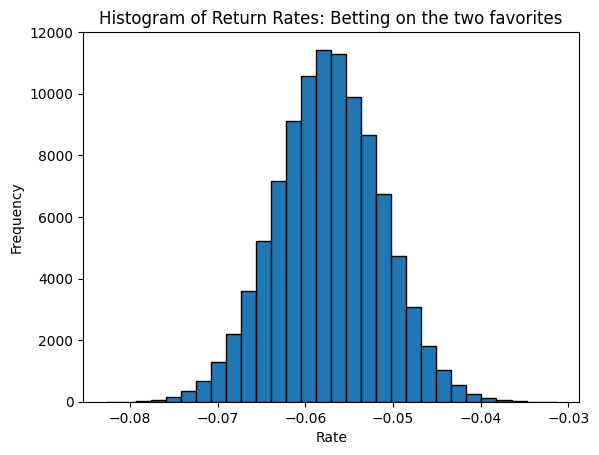

In [22]:
ReturnRate = []
#Run 100000 simulations
for n in range(100000):
    #In each take a sample with replacement of the same lenght than the original df
    df_sample = df.sample(frac=1, replace=True)
    #Calculate the return rate by dividing the profits by the amount bet (Assume 1 dollar bet for all the matches)
    ReturnRate.append((df_sample[df_sample['profit']>0]['profit'].sum() - len(df_sample))/len(df_sample))
plt.hist(ReturnRate, bins=30, edgecolor='k')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Return Rates: Betting on the two favorites')
plt.show()

In [23]:
# Calculate the 90% confidence interval for the Rates
mean_rate = np.mean(ReturnRate)
lower_bound = np.percentile(ReturnRate, 5)
upper_bound = np.percentile(ReturnRate, 95)

print(lower_bound, mean_rate, upper_bound)

-0.0672042040508465 -0.05733062571720879 -0.04755837758049919


Again, after making a bootstrap distribution of the profit rates using this new strategy, it's clear that in the long run, we are going to lose money (or the casino will earn money from us). This time we can expect to lose around 6% of our money. If we establish an interval for this expected value with a 90% confidence, we're going to lose between 7% and 5% of our money (Casino's Profit).

## Analyzing the strategy: Betting on the Favorite

In [24]:
#Here we set the won column to 1 if the strategy wins the bet
df['Won'] = np.where(df['WinOdd'] == df['MinOdd'], 1,0)
#The we create a profit column, if Won the Odd, else -1
df['profit'] = df['Won'] * df['MinOdd']
df['profit'] = np.where(df['profit']==0, -1, df['profit'])
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,Result,WinOdd,MinOdd,MiddleOdd,MaxOdd,OddCNF,OddSNF,Fav,Les_favorite,Sec_favorite,Won,profit
0,30/07/2022,Dijon,St Etienne,2,1,2.87,3.2,2.37,0,2.87,2.37,2.87,3.20,1.513015,1.298073,2,1.0,0,0,-1.00
1,30/07/2022,Annecy,Niort,1,2,2.30,3.2,2.90,2,2.90,2.30,2.90,3.20,1.521311,1.282692,0,1.0,2,0,-1.00
2,30/07/2022,Bastia,Laval,0,2,2.00,3.1,3.75,2,3.75,2.00,3.10,3.75,1.697080,1.215686,0,2.0,1,0,-1.00
3,30/07/2022,Bordeaux,Valenciennes,0,0,2.50,3.1,2.75,1,3.10,2.50,2.75,3.10,1.457265,1.309524,0,1.0,2,0,-1.00
4,30/07/2022,Guingamp,Pau FC,4,0,1.65,3.5,5.00,0,1.65,1.65,3.50,5.00,2.058824,1.121359,0,2.0,1,1,1.65


### Histogram and confidence interval

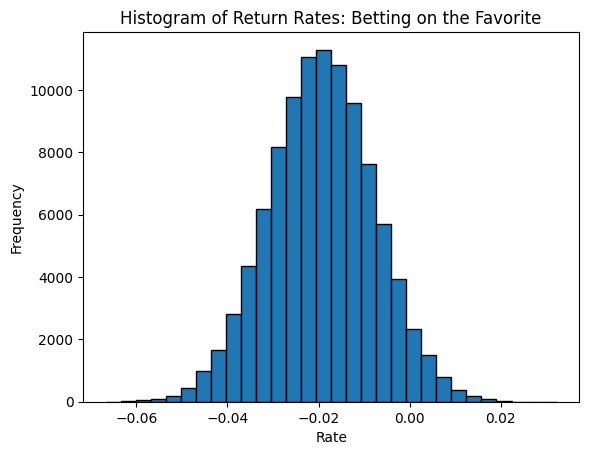

In [25]:
ReturnRate = []
#Run 100000 simulations
for n in range(100000):
    #In each take a sample with replacement of the same lenght than the original df
    df_sample = df.sample(frac=1, replace=True)
    #Calculate the return rate by dividing the profits by the amount bet (Assume 1 dollar bet for all the matches)
    ReturnRate.append((df_sample[df_sample['profit']>0]['profit'].sum() - len(df_sample))/len(df_sample))
plt.hist(ReturnRate, bins=30, edgecolor='k')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Return Rates: Betting on the Favorite')
plt.show()

In [26]:
# Calculate the 90% confidence interval for the Rates
mean_rate = np.mean(ReturnRate)
lower_bound = np.percentile(ReturnRate, 5)
upper_bound = np.percentile(ReturnRate, 95)

print(lower_bound, mean_rate, upper_bound)

-0.03826058956313895 -0.019310593095206486 -0.0004247111937327107


At last, but not least, after making a bootstrap distribution of the profit rates using the bet-on-the-favorite strategy, it again appears clear that in the long run, we are going to lose money (or the casino will earn money from us). With this strategy, the expected value is to lose around 2% of our money. If we establish an interval for this expected value with a 90% confidence, we're going to lose around  4% to 0.04%.

## Conclusions

Regardless of the other strategies I did not analyze, I'm pretty sure they all yield the same results. In the long run, the casino wins, and you lose.

We just saw that the house always wins no matter what, but we still haven't discussed how they ensure this. At this point, I will use a concept that is going to help us figure it out: "Expected Value".

Expected value is a powerful concept which detailed explanation is out of the scope of this project. Nonetheless, we can provide an example to understand it.

If you and one of your friends are planning to bet on the flip of a coin, would you accept if you get paid 90 cents every time it lands tails and pay 1 dollar otherwise? Probably not. You will think: "Half the time I will win and half the time I will lose, so, if I play 100 times, I expect to win 45 dollars (50 * 0.9) and lose 50 dollars (50 * 1), so I will end up losing 5 dollars.

Of course, if you play 5 times you could win some money, but the more you play, the closer you get to losing than to winning.

The same happens with the casinos. Consider the following odds for a game: H=2.87, D=3.2, A=2.37, which in probabilities translate to: H=35%, D=31%, A=42% (1 / odd * 100). If you sum them, it results in 108%. This time, the same thing is happening as with the coin; the casino raises the actual probabilities so the odds get lower, and you get paid less than you should in a fair event, that's the way casinos make money. They only have to think about assigning enough lower probabilities in order to pay you less, they win the more you play and, from the above analysis, we can see they're very good at it.

With all this said, sports bets should be seen as a recreational activity and not as an investment or a way to make a living off it. Anyone who tells you otherwise might be a scammer.